In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np; np.random.seed(42)
import seaborn as sns

import pyLDAvis
import pyLDAvis.gensim
from collections import OrderedDict
from itertools import combinations
import MeCab
from konlpy.tag import *
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import normalize;
from sklearn import decomposition;

/Users/gimjaewon/opt/anaconda3/envs/venv/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
/Users/gimjaewon/opt/anaconda3/envs/venv/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
/Users/gimjaewon/opt/anaconda3/envs/venv/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/gimjaewon/opt/anaconda3/envs/venv/l

In [2]:
df = pd.read_csv('adoor_data/sns_feed.csv', encoding='UTF8')
df['created_at'] = pd.to_datetime(df['created_at'])

# df = df[(df.author_id != 5)]

start_date = pd.Timestamp(2019, 1, 28, 0)
end_date = pd.Timestamp(2019, 4, 1, 0)

mask = (df['created_at'] > start_date) & (df['created_at'] <= end_date)
df = df.loc[mask]

df.head()

,adoor,SNS,SNS 아이디,private,created_at,photo,content
0,2,facebook,김유리,False,2019-02-08,홍보,저와 팀원들이 영혼을 갈아넣은 서비스 베타버전이 드디어 나왔어요!!🤩\n밤잠을 줄여...
1,2,instagram,nnnyu_ri,False,2019-02-08,홍보,https://adoor.app @adoor.team\n저와 팀원들이 영혼을 갈아넣...
2,2,instagram,yulo_mon,True,2019-02-07,"가족, 아기, 강아지",카조꾸또 잇쇼니 토떼모 우레시깟딴데쓰
3,2,instagram,yulo_mon,True,2019-02-25,일상,🙋🏻‍♀️
4,2,instagram,yulo_mon,True,2019-03-02,나들이,필름캐머러 첫 롤 사진들1\n수라미가 준 로모그래피 심플유즈 기본 장착 컬러네거티브...


In [3]:
twitter = Okt()
pos = lambda d: ['/'.join(p) for p in twitter.pos(d, stem=True, norm=True)]

texts_ko = []
content = df.content
docs_ko = ""

for row in content:
    text = row
    if not pd.isna(text):
        docs_ko = docs_ko + text
        for morph in pos(text):
            if (morph.split('/')[1]) in ['Noun'] and len(morph.split('/')[0]) > 1:
                m = []
                m.append(morph)
                texts_ko.append(m)

In [4]:
dictionary_ko = corpora.Dictionary(texts_ko)
dictionary_ko.save('ko.dict')

In [5]:
tf_ko = [dictionary_ko.doc2bow(text) for text in texts_ko]
tfidf_model_ko = models.TfidfModel(tf_ko)
tfidf_ko = tfidf_model_ko[tf_ko]
corpora.MmCorpus.serialize('ko.mm', tfidf_ko)

In [6]:
ntopics, nwords = 5, 5

lda_ko = models.ldamodel.LdaModel(tf_ko, id2word=dictionary_ko, num_topics=ntopics)
lda_ko.print_topics()

[(0,
  '0.018*"오늘/Noun" + 0.018*"시간/Noun" + 0.015*"머리/Noun" + 0.013*"스님/Noun" + 0.010*"거리/Noun" + 0.008*"걸음/Noun" + 0.008*"아침/Noun" + 0.008*"지금/Noun" + 0.006*"시점/Noun" + 0.006*"공유/Noun"'),
 (1,
  '0.029*"사람/Noun" + 0.017*"아주/Noun" + 0.015*"시스템/Noun" + 0.010*"여자/Noun" + 0.010*"모든/Noun" + 0.010*"가입/Noun" + 0.008*"사진/Noun" + 0.008*"이유/Noun" + 0.008*"제일/Noun" + 0.008*"다른/Noun"'),
 (2,
  '0.027*"생각/Noun" + 0.021*"그것/Noun" + 0.018*"우리/Noun" + 0.016*"학교/Noun" + 0.009*"그녀/Noun" + 0.009*"일단/Noun" + 0.009*"상태/Noun" + 0.009*"누구/Noun" + 0.009*"베타/Noun" + 0.007*"진짜/Noun"'),
 (3,
  '0.024*"사람/Noun" + 0.024*"마음/Noun" + 0.011*"대한/Noun" + 0.011*"필름/Noun" + 0.011*"모두/Noun" + 0.008*"진짜/Noun" + 0.008*"공개/Noun" + 0.008*"정말/Noun" + 0.008*"고생/Noun" + 0.008*"무척/Noun"'),
 (4,
  '0.019*"친구/Noun" + 0.015*"사용/Noun" + 0.012*"소리/Noun" + 0.012*"방학/Noun" + 0.010*"동안/Noun" + 0.010*"사진/Noun" + 0.010*"버전/Noun" + 0.010*"일이/Noun" + 0.010*"매일/Noun" + 0.010*"그냥/Noun"')]

In [7]:
lda_ko = models.ldamodel.LdaModel(tfidf_ko, id2word=dictionary_ko, num_topics=ntopics)
lda_ko.print_topics()

[(0,
  '0.048*"사람/Noun" + 0.020*"아주/Noun" + 0.018*"마음/Noun" + 0.013*"시스템/Noun" + 0.013*"머리/Noun" + 0.013*"사용/Noun" + 0.013*"사진/Noun" + 0.011*"모든/Noun" + 0.009*"일단/Noun" + 0.009*"당신/Noun"'),
 (1,
  '0.020*"진짜/Noun" + 0.020*"스님/Noun" + 0.018*"학교/Noun" + 0.015*"그것/Noun" + 0.010*"필름/Noun" + 0.010*"무척/Noun" + 0.010*"후회/Noun" + 0.010*"거리/Noun" + 0.008*"위해/Noun" + 0.008*"몹시/Noun"'),
 (2,
  '0.023*"오늘/Noun" + 0.013*"일이/Noun" + 0.011*"생각/Noun" + 0.011*"모두/Noun" + 0.011*"그냥/Noun" + 0.008*"가입/Noun" + 0.008*"약간/Noun" + 0.008*"세상/Noun" + 0.008*"방법/Noun" + 0.008*"대한/Noun"'),
 (3,
  '0.019*"우리/Noun" + 0.014*"생각/Noun" + 0.012*"방학/Noun" + 0.010*"전깃줄/Noun" + 0.010*"공개/Noun" + 0.010*"소리/Noun" + 0.010*"누구/Noun" + 0.007*"그것/Noun" + 0.007*"다시/Noun" + 0.007*"고생/Noun"'),
 (4,
  '0.021*"친구/Noun" + 0.013*"시간/Noun" + 0.011*"매일/Noun" + 0.011*"그녀/Noun" + 0.008*"벌써/Noun" + 0.008*"서비스/Noun" + 0.008*"다른/Noun" + 0.006*"생각/Noun" + 0.006*"사진/Noun" + 0.006*"베타/Noun"')]

In [8]:
ldatopics = lda_ko.show_topics(formatted=False)
ldatopics[0]

(0,
 [('사람/Noun', 0.047894664),
  ('아주/Noun', 0.019762902),
  ('마음/Noun', 0.017659059),
  ('시스템/Noun', 0.013427526),
  ('머리/Noun', 0.013397738),
  ('사용/Noun', 0.013382606),
  ('사진/Noun', 0.01333818),
  ('모든/Noun', 0.011224575),
  ('일단/Noun', 0.009120527),
  ('당신/Noun', 0.009052118)])

In [9]:
lsi_ko = models.lsimodel.LsiModel(tfidf_ko, id2word=dictionary_ko, num_topics=ntopics)
lsi_ko.print_topics()

[(0,
  '1.000*"사람/Noun" + 0.001*"무엇/Noun" + 0.001*"네이버/Noun" + 0.001*"기록/Noun" + 0.001*"코피/Noun" + 0.001*"직접/Noun" + 0.001*"저녁/Noun" + 0.000*"갑자기/Noun" + 0.000*"비합리적/Noun" + -0.000*"가장/Noun"'),
 (1,
  '-1.000*"생각/Noun" + 0.005*"계정/Noun" + 0.005*"갑자기/Noun" + 0.004*"서비스/Noun" + -0.003*"의미/Noun" + -0.003*"예지/Noun" + 0.003*"코코/Noun" + 0.003*"상처/Noun" + 0.003*"퓨저/Noun" + -0.003*"거의/Noun"'),
 (2,
  '0.571*"아주/Noun" + -0.530*"오늘/Noun" + -0.487*"마음/Noun" + 0.393*"그것/Noun" + -0.006*"해외/Noun" + -0.005*"순간/Noun" + -0.005*"걸음/Noun" + 0.005*"바지/Noun" + 0.005*"명상/Noun" + 0.004*"처음/Noun"'),
 (3,
  '-0.625*"아주/Noun" + -0.619*"오늘/Noun" + 0.396*"그것/Noun" + 0.261*"마음/Noun" + 0.009*"거의/Noun" + 0.007*"저리/Noun" + 0.007*"시대/Noun" + 0.006*"추억/Noun" + 0.006*"기억/Noun" + -0.005*"이해/Noun"'),
 (4,
  '-0.749*"그것/Noun" + -0.574*"오늘/Noun" + 0.258*"마음/Noun" + 0.203*"아주/Noun" + 0.010*"기억/Noun" + -0.009*"지금/Noun" + -0.007*"안보/Noun" + 0.007*"약간/Noun" + -0.007*"보고/Noun" + 0.006*"후회/Noun"')]

In [10]:
hdp_ko = models.hdpmodel.HdpModel(tfidf_ko, id2word=dictionary_ko)
hdp_ko.print_topics(ntopics, nwords)

/Users/gimjaewon/opt/anaconda3/envs/venv/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


[(0,
  '0.008*템플스테이/Noun + 0.007*과제/Noun + 0.007*검도/Noun + 0.007*내장/Noun + 0.007*포자/Noun'),
 (1,
  '0.009*뇌수/Noun + 0.009*방법/Noun + 0.007*아렁/Noun + 0.007*토떼모/Noun + 0.006*이제/Noun'),
 (2,
  '0.008*캐머러/Noun + 0.008*사실/Noun + 0.007*주무/Noun + 0.006*라떼/Noun + 0.006*가슴/Noun'),
 (3,
  '0.008*소름/Noun + 0.008*촥촥촥/Noun + 0.007*일이/Noun + 0.006*종일/Noun + 0.006*세계/Noun'),
 (4,
  '0.008*산수/Noun + 0.007*졸업식/Noun + 0.007*저기/Noun + 0.007*자극/Noun + 0.007*과제/Noun')]

In [11]:
bow = tfidf_model_ko[dictionary_ko.doc2bow(texts_ko[0])]
sorted(lda_ko[bow], key=lambda x: x[1], reverse=True)

[(2, 0.5999361),
 (1, 0.10001727),
 (4, 0.10001664),
 (3, 0.10001513),
 (0, 0.100014836)]

In [12]:
sorted(hdp_ko[bow], key=lambda x: x[1], reverse=True)

[(51, 0.5035432698133189)]

In [13]:
bow = tfidf_model_ko[dictionary_ko.doc2bow(texts_ko[1])]
sorted(lda_ko[bow], key=lambda x: x[1], reverse=True)

[(4, 0.5999541),
 (2, 0.10001239),
 (3, 0.100011915),
 (1, 0.100011356),
 (0, 0.10001023)]

In [14]:
sorted(hdp_ko[bow], key=lambda x: x[1], reverse=True)

[(84, 0.5033264730388654)]

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=tf_ko, num_topics=num_topics, id2word=dictionary_ko)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts_ko, dictionary=dictionary_ko, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
coherence_model_lda = models.CoherenceModel(model=lda_ko, texts=texts_ko, dictionary=dictionary_ko, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.8491372539412712


In [17]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary_ko, 
    corpus=tf_ko, 
    texts=texts_ko, 
    start=1, 
    limit=10, 
    step=1)

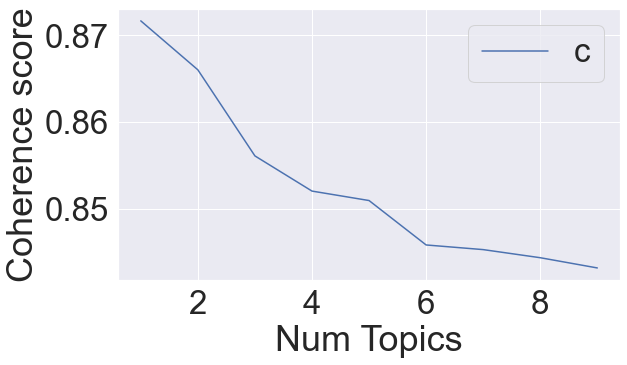

In [34]:
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.rcParams["font.size"] = 2
plt.figure(figsize=(9,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.8717
Num Topics = 2  has Coherence Value of 0.866
Num Topics = 3  has Coherence Value of 0.8561
Num Topics = 4  has Coherence Value of 0.852
Num Topics = 5  has Coherence Value of 0.8509
Num Topics = 6  has Coherence Value of 0.8458
Num Topics = 7  has Coherence Value of 0.8453
Num Topics = 8  has Coherence Value of 0.8443
Num Topics = 9  has Coherence Value of 0.8431


In [20]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.008*"사람/Noun" + 0.007*"친구/Noun" + 0.007*"사진/Noun" + 0.006*"마음/Noun" + 0.005*"우리/Noun" + 0.005*"시간/Noun" + 0.005*"사용/Noun" + 0.005*"그것/Noun" + 0.005*"머리/Noun" + 0.004*"생각/Noun"'),
 (1,
  '0.015*"사람/Noun" + 0.009*"생각/Noun" + 0.008*"아주/Noun" + 0.008*"진짜/Noun" + 0.006*"스님/Noun" + 0.006*"오늘/Noun" + 0.005*"그것/Noun" + 0.005*"학교/Noun" + 0.005*"시스템/Noun" + 0.005*"일단/Noun"')]

In [21]:
def format_topics_sentences(ldamodel=lda_ko, corpus=tf_ko, texts=df['content'].values.astype('U')):
   
    sent_topics_df = pd.DataFrame()

   
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # -- dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=tf_ko, texts=df['content'].values.astype('U'))


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.6617,"사람/Noun, 친구/Noun, 사진/Noun, 마음/Noun, 우리/Noun, 시...",저와 팀원들이 영혼을 갈아넣은 서비스 베타버전이 드디어 나왔어요!!🤩\n밤잠을 줄여...
1,1,0.0,0.7000,"사람/Noun, 친구/Noun, 사진/Noun, 마음/Noun, 우리/Noun, 시...",https://adoor.app @adoor.team\n저와 팀원들이 영혼을 갈아넣...
2,2,1.0,0.5572,"사람/Noun, 생각/Noun, 아주/Noun, 진짜/Noun, 스님/Noun, 오...",카조꾸또 잇쇼니 토떼모 우레시깟딴데쓰
3,3,1.0,0.6028,"사람/Noun, 생각/Noun, 아주/Noun, 진짜/Noun, 스님/Noun, 오...",🙋🏻‍♀️
4,4,0.0,0.7261,"사람/Noun, 친구/Noun, 사진/Noun, 마음/Noun, 우리/Noun, 시...",필름캐머러 첫 롤 사진들1\n수라미가 준 로모그래피 심플유즈 기본 장착 컬러네거티브...


In [22]:
path='/Library/Fonts/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
matplotlib.rc('font', family=font_name)
matplotlib.rc('axes', unicode_minus=False)
plt.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)

In [23]:
# Latent Dirichlet Allocation, LDA is yet another transformation from 
# bag-of-words counts into a topic space of lower dimensionality. 
# LDA is a probabilistic extension of LSA (also called multinomial PCA), 
# so LDA’s topics can be interpreted as probability distributions over words. 
# These distributions are, just like with LSA, inferred automatically from 
# a training corpus. Documents are in turn interpreted as a (soft) mixture 
# of these topics (again, just like with LSA)

In [24]:
data_lda = {i: OrderedDict(lda_ko.show_topic(i, 5)) for i in range(5)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)
df_lda

(5, 24)


,사람/Noun,아주/Noun,마음/Noun,시스템/Noun,머리/Noun,진짜/Noun,스님/Noun,학교/Noun,그것/Noun,필름/Noun,...,그냥/Noun,우리/Noun,방학/Noun,전깃줄/Noun,공개/Noun,친구/Noun,시간/Noun,매일/Noun,그녀/Noun,벌써/Noun
0,0.047895,0.019763,0.017659,0.013428,0.013398,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.020397,0.020298,0.017904,0.015359,0.010444,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010695,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.018745,0.011881,0.009661,0.009624,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.021207,0.013481,0.010865,0.010833,0.008284


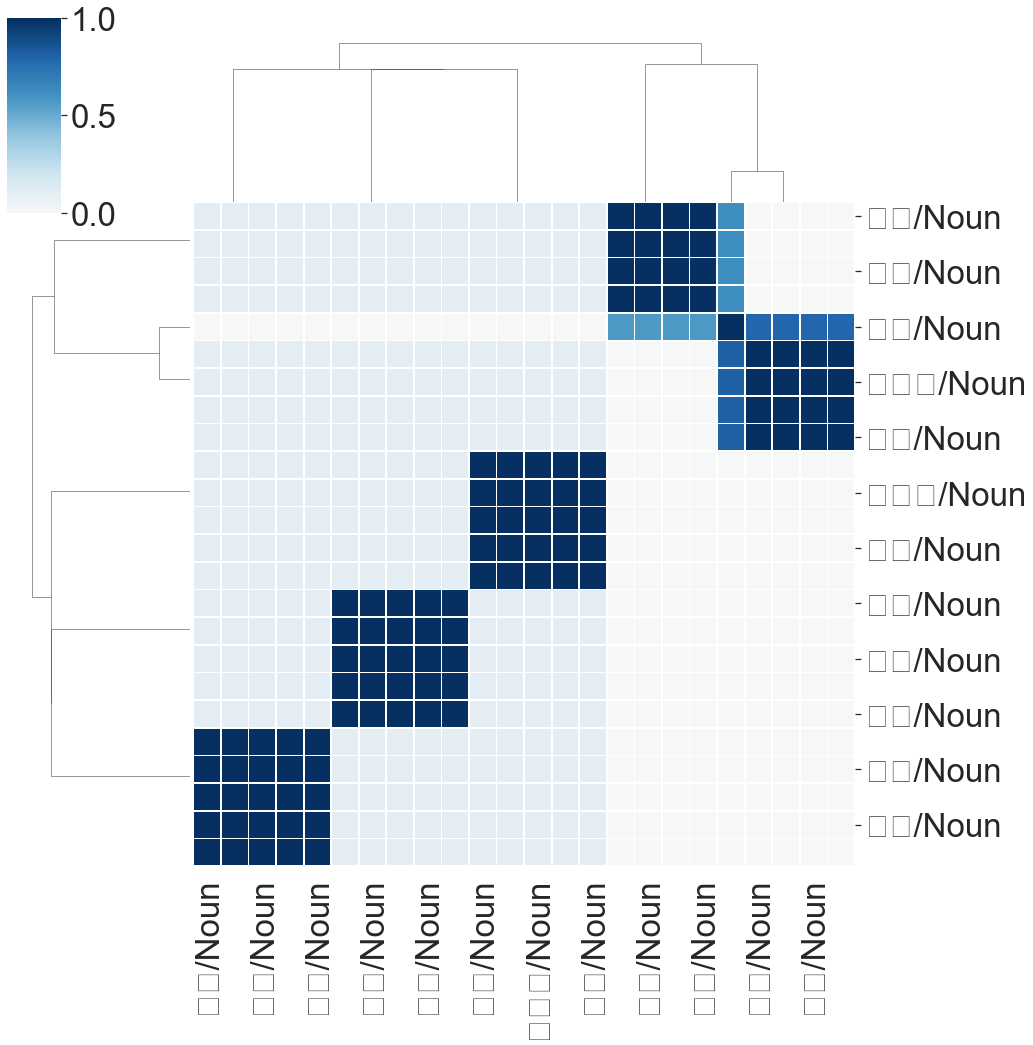

In [25]:
sns.set(font_scale=3)
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [26]:
corpus_lda = lda_ko[tfidf_ko]

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda_ko, corpus_lda, dictionary_ko, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  27.455202
1       51.163364 -159.968018       2        1  20.864819
2      -73.144554   21.523815       3        1  20.763447
0      -66.410133 -110.606438       4        1  20.119873
3       54.417324   12.443444       5        1  10.796659, topic_info=        Term       Freq      Total Category  logprob  loglift
117  사람/Noun  12.000000  12.000000  Default  30.0000  30.0000
249  오늘/Noun   6.000000   6.000000  Default  29.0000  29.0000
11   친구/Noun   7.000000   7.000000  Default  28.0000  28.0000
58   진짜/Noun   5.000000   5.000000  Default  27.0000  27.0000
137  스님/Noun   5.000000   5.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
66   그것/Noun   0.981358   5.466855   Topic5  -4.9044   0.5084
173  일단/Noun   0.681630   3.430338   Topic5  -5.2688   0.6100
170  제일/Noun   0.672023   3.017281   Topic5  -5.2830   0.7241
299  어도/Noun   0.670735   2.552627   Topic5  -5.2850   0.8894
384  기록/Noun   0.669331   2.135792   Topic5  -5.2871   1.0656

[222 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
229       3  0.685410   가입/Noun
125       5  0.636197   가장/Noun
59        5  0.634980  갑자기/Noun
540       4  0.585988   개강/Noun
54        1  0.403715   거기/Noun
...     ...       ...       ...
269       5  0.635909   해외/Noun
82        1  0.842082   허리/Noun
193       5  0.796302   허슬/Noun
39        1  0.842587   헤헤/Noun
230       2  0.935842   후회/Noun

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 1, 4])

In [27]:
def getNVM_lemma(text):
    tokenizer = MeCab.Tagger()
    parsed = tokenizer.parse(text)
    word_tag = [w for w in parsed.split("\n")]
    pos = []
    tags = ['NNG','NNP','VV','VA', 'VX', 'VCP','VCN']
    for word_ in word_tag[:-2]:
        word = word_.split("\t")
        tag = word[1].split(",")
        if(len(word[0]) < 2) or ("게" in word[0]):
            continue
        if(tag[-1] != '*'):
            t = tag[-1].split('/')
            if(len(t[0]) > 1 and ('VV' in t[1] or 'VA' in t[1] or 'VX' in t[1])):
                pos.append(t[0])
        else:
            if(tag[0] in tags):
                pos.append(word[0])
    return pos

In [28]:
vectorizer = CountVectorizer(tokenizer=getNVM_lemma, min_df=2)
x_counts = vectorizer.fit_transform(df['content'].values.astype('U'))
print( "Created %d X %d document-term matrix" % (x_counts.shape[0], x_counts.shape[1]) )
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

Created 135 X 137 document-term matrix


In [29]:
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 137 distinct terms


In [30]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)
model = NMF(n_components=10, init='nndsvd');
model.fit(xtfidf_norm)

NMF(init='nndsvd', n_components=10)

In [31]:
def get_nmf_topics(model, n_top_words):
    
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        words_ids = model.components_[i].argsort()[:-10 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [32]:
num_topics = 5
nmf_df = get_nmf_topics(model, 5)
nmf_df

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,날씨,도어,민윤기,최고,친구
1,생일,소통,허리,재재,고맙
2,시작,관심,기다리,보내,필름
3,기념,관계,세상,낌새,만들
4,카메라,공유,따르,자르,사용
5,필름,오늘,재밌,방법,공유
6,개강,보내,머리,머리,머러
7,기분,그리,떠나,보이,소통
8,지나,공개,순간,모르,사진
9,열리,방학,건너,따르,나오


In [33]:
num_topics = 10
nmf_df = get_nmf_topics(model, 5)
nmf_df

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,날씨,도어,민윤기,최고,친구,생각,언니,노래,강아지,이렇
1,생일,소통,허리,재재,고맙,고맙,새벽,라이프,서비스,재미
2,시작,관심,기다리,보내,필름,세상,이미지,디자인,그리,통제
3,기념,관계,세상,낌새,만들,통제,기억,생기,흘리,기다리
4,카메라,공유,따르,자르,사용,필름,엄청나,사람,공유,허리
5,필름,오늘,재밌,방법,공유,사진,붙이,돌리,재재,다가오
6,개강,보내,머리,머리,머러,돌리,교수,들리,허리,사진
7,기분,그리,떠나,보이,소통,머러,학교,이틀,보내,아니
8,지나,공개,순간,모르,사진,기대,기대,존재,낌새,느끼
9,열리,방학,건너,따르,나오,방법,방법,그러,자르,사람
